# Exercise4 Report - planet

## lesson
* lession 3 Multi-label classification and Segmentation

## student
* 20161622 이예은

## Multi-label prediction with Planet Amazon dataset

In [21]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/exercise4'

# mounting at google drive for Kaggle

Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Any edits to libraries you make are reloaded here automatically and any charts or images displayed are shown in this notebook.

In [0]:
from fastai.vision import *

# Import necessary library 

## Getting the data using Kaggle API


Install [Kaggle API](https://github.com/Kaggle/kaggle-api) for getting [the planet data set](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data). 



In [4]:
 ! {sys.executable} -m pip install kaggle --upgrade
 # Install Kaggle api using pip

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)



Download API token in kaggle page and upload this file.
Next, I have to the accept rules in competition page. 
![kaggle.json](https://drive.google.com/uc?id=1a8CkqffkklrswJga3JUk94HnSKHYdf9d)

In [0]:
 ! mkdir -p ~/.kaggle/
 ! mv "$base_dir/kaggle/kaggle.json" ~/.kaggle/


# Upload 'kaggle.json' to '$base_dir/kaggle/'
# And, move the data to '~/.kaggle/'

In [78]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

#Set path for downloading data from kaggle

PosixPath('/root/.fastai/data/planet')

In [79]:
 # ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p '$path'  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv/train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

# download train_v2.csv file using kaggle api and unzip

  0% 0.00/151k [00:00<?, ?B/s]
100% 151k/151k [00:00<00:00, 56.0MB/s]


'kaggle competition download train-jpg.tar.7z' command is not working in colab.(I guess it's because this file is too big)
So after downloading this file from [kaggle page for planet data](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data'), I upload my drive and move to path.
![mydrive](https://drive.google.com/uc?id=1ailuSrExZZ2LUIOl1woB11NcAv7k48_9)



In [0]:
! mv "$base_dir/kaggle/train-jpg.tar.7z" {path}

# train-jpg.tar.7z can't download using 'kaggle competition dowload' command in colab
# so I download this file from kaggle page 'https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data' and move path

In [81]:
 #!conda install --yes --prefix {sys.prefix} -c haasad eidl7zip
 ! sudo apt install p7zip-full

 # Extract the content of the file

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
 ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}
 # Unpack data

## Multiclassification

In multiclassificationm each data can have multiple labels.

In [96]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

# read csv files 
# Q. df means data frame?

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Should use ImageList instead of ImageDataBunch to create a DataBunch in multiple classes while using the [data block API](https://docs.fast.ai/data_block.html). 


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

# Set 'vertical flip' to True (default is False)
# Set 'max_warp'(symetric changes) to zero 

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

# Set random seed to 42
# Should use ImageList instead of ImageDataBunch to create a DataBunch in multiple classes. 


In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
# transform data and normalize

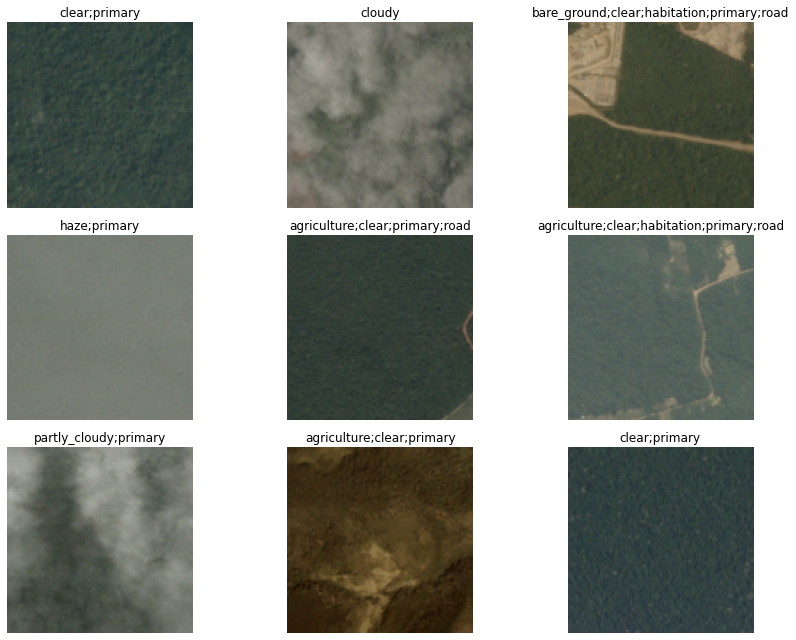

In [88]:
data.show_batch(rows=3, figsize=(12,9))

# show a batch of data 

Use accuracy_tresh instead of accuracy in this case. 
Accuracy_tresh is 0(not over accuracy_tresh) or 1(over accuracy_tresh).

In [0]:
arch = models.resnet50
#set architecture to resnet50 model

In [94]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

# Use accuracy_tresh(be 0. or 1. by accuracy_tresh hold) instead of accuracy(pick biggest)
# f_score is a metric for evalution using Fbeta

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


pick a good learning rate.

In [100]:
learn.lr_find()
# find learning rate

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


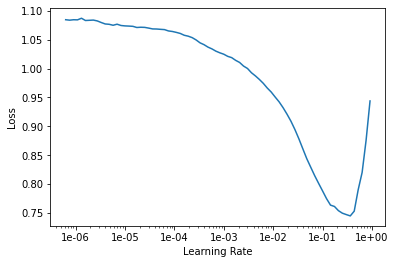

In [97]:
learn.recorder.plot()
# show graph about the loss and the learning rate

In [0]:
lr = 0.01
# set learning rate 0.01

In [103]:
learn.fit_one_cycle(5, slice(lr))
#lean 5 cycles

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.138312,0.115815,0.944948,0.898713,02:25
1,0.110105,0.099573,0.951081,0.913391,02:20
2,0.101378,0.091609,0.950209,0.917390,02:21
3,0.098446,0.087949,0.956967,0.924517,02:19
4,0.091252,0.086848,0.956138,0.925470,02:17


In [0]:
learn.save('stage-1-rn50')
# save the parameters in model.

fine-tune the whole model

In [0]:
learn.unfreeze()
# learn using a whole models for fine-tunning

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


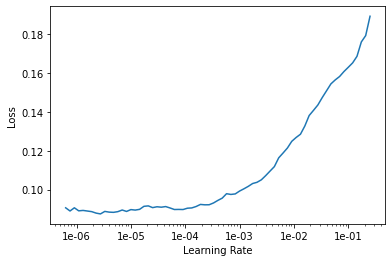

In [106]:
learn.lr_find()
learn.recorder.plot()
#Find learning rate
#and show graph about the loss and the learning rate

In [107]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))
# learnning 5 cycles

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097489,0.092595,0.956182,0.918921,02:22
1,0.096536,0.090885,0.955165,0.922245,02:22
2,0.091038,0.086470,0.958006,0.927063,02:22
3,0.085066,0.082860,0.956712,0.928158,02:27
4,0.079172,0.082620,0.958478,0.928919,02:24


In [0]:
learn.save('stage-2-rn50')
# save the parameters in model.

If increase size of data image, you can get more accurate classification.

In [109]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

# Increase size of data image

torch.Size([3, 256, 256])

In [0]:
learn.freeze()
# freeze models

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


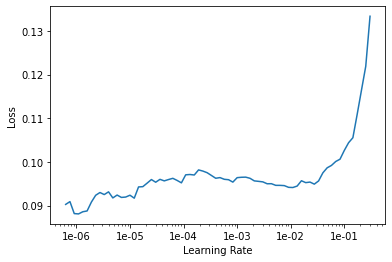

In [111]:
learn.lr_find()
learn.recorder.plot()
# find learnning rate and show graph

In [0]:
lr=1e-2/2
#set learnning rate

In [113]:
learn.fit_one_cycle(5, slice(lr))
# learnning 5 cycles

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090769,0.085130,0.957723,0.927287,04:15
1,0.089681,0.083408,0.959888,0.928251,04:14
2,0.084375,0.082770,0.958878,0.927936,04:16
3,0.082754,0.081632,0.958805,0.929147,04:15
4,0.079304,0.081876,0.959968,0.929729,04:14


In [0]:
learn.save('stage-1-256-rn50')
# save the parameters in model.

In [0]:
learn.unfreeze()
# lean using whole models

In [116]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))
# learn 5 cycles

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084368,0.084036,0.959794,0.928008,04:31
1,0.085435,0.084013,0.957955,0.927140,04:34
2,0.083234,0.081931,0.958885,0.929180,04:32
3,0.076893,0.080907,0.960869,0.930922,04:30
4,0.077030,0.080553,0.960033,0.930817,04:32


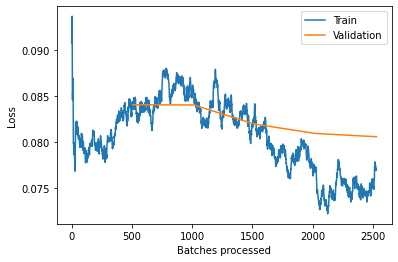

In [119]:
learn.recorder.plot_losses()
# show recorde of losses

In [0]:
learn.save('stage-2-256-rn50')
# save the parameters in model.

In [0]:
learn.export()
# export the parameters in learnning model

## fin

Submit result to Kaggle(This section will be covered in part 2 - please don't ask about it just yet! :) )

![alt text](https://drive.google.com/uc?id=1lmfh31yR9HiqxUUVJqdOmShyzX3IBwPL)


In [0]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

! cp "$base_dir/kaggle/test-jpg.tar.7z" {path}
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! cp "$base_dir/kaggle/test-jpg-additional.tar.7z" {path}
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

#download test-jpg and move to path

In [124]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)
# print the number of images

61191

In [125]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

#load exported learner and run models 

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
# set predicted result over 0.2 to labelled_preds

In [127]:
labelled_preds[:5]
# show 5 labelled_preds 

['agriculture partly_cloudy primary road',
 'clear primary',
 'clear haze primary road water',
 'agriculture clear primary',
 'partly_cloudy primary water']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
# set file name

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
# set data bunch

In [0]:
df.to_csv(path/'submission.csv', index=False)
# make data bunch to csv files

In [131]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"
#upload  to kaggle 

100% 2.20M/2.20M [00:03<00:00, 749kB/s] 
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)